In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# EDA

In [2]:
df = pd.read_csv('/kaggle/input/playground-series-s6e1/train.csv')
test_df = pd.read_csv('/kaggle/input/playground-series-s6e1/test.csv')

In [3]:
df.shape

(630000, 13)

In [4]:
df.dtypes

id                    int64
age                   int64
gender               object
course               object
study_hours         float64
class_attendance    float64
internet_access      object
sleep_hours         float64
sleep_quality        object
study_method         object
facility_rating      object
exam_difficulty      object
exam_score          float64
dtype: object

In [5]:
for col in df.select_dtypes(include=['object']).columns:
    print(f"{col}: {df[col].nunique()} unique classes")

gender: 3 unique classes
course: 7 unique classes
internet_access: 2 unique classes
sleep_quality: 3 unique classes
study_method: 5 unique classes
facility_rating: 3 unique classes
exam_difficulty: 3 unique classes


Not to many unique classes, which is nice when training a model 

In [6]:
df.isnull().sum()


id                  0
age                 0
gender              0
course              0
study_hours         0
class_attendance    0
internet_access     0
sleep_hours         0
sleep_quality       0
study_method        0
facility_rating     0
exam_difficulty     0
exam_score          0
dtype: int64

In [7]:
df.duplicated().sum()

np.int64(0)

## Subplots

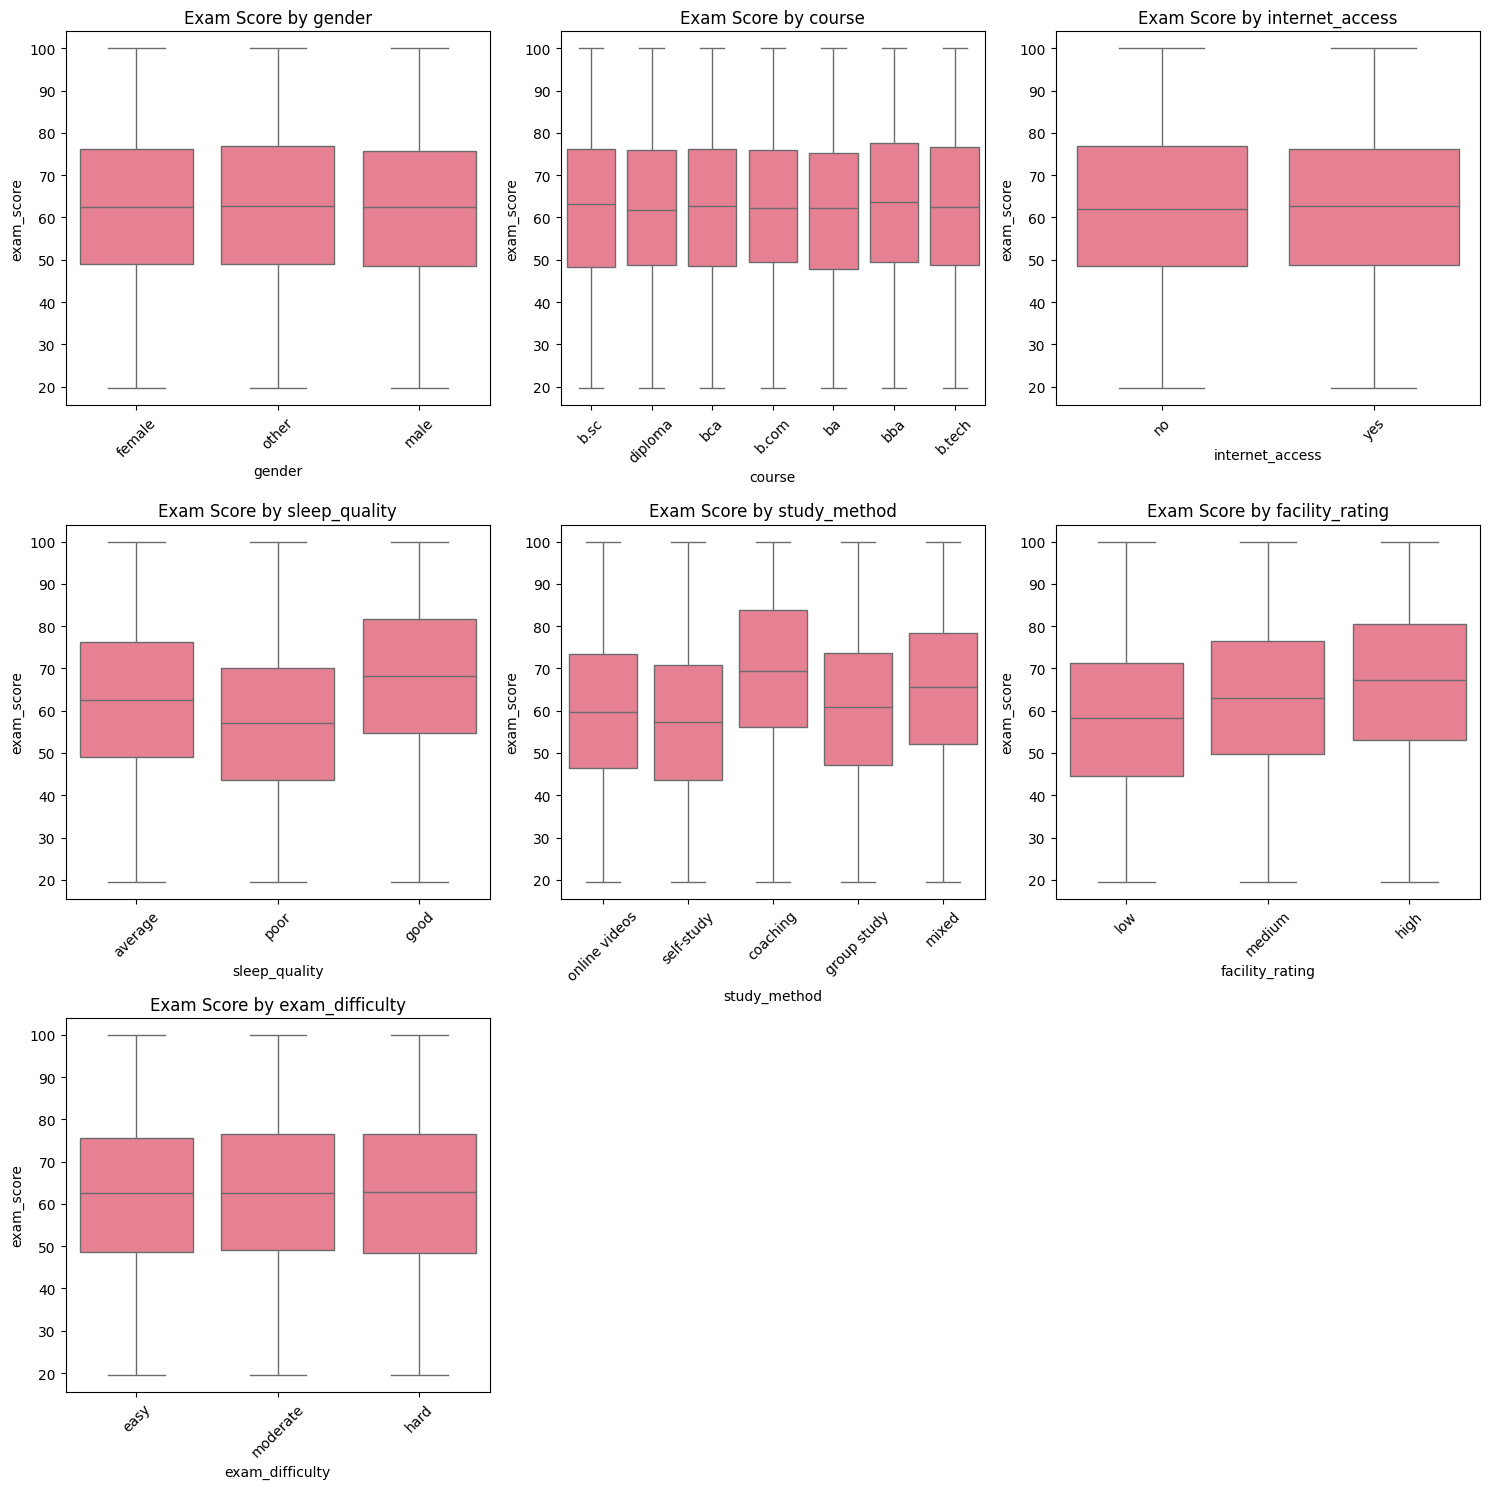

In [8]:
# Set up the plotting style
plt.style.use('default')
sns.set_palette("husl")

# Get categorical columns only
categorical_features = [col for col in df.select_dtypes(include=['object']).columns]

# Calculate number of rows and columns for subplots
n_features = len(categorical_features)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols

# Create figure with subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes

for i, feature in enumerate(categorical_features):
    ax = axes[i]
    
    # Create boxplot for categorical variables
    sns.boxplot(data=df, x=feature, y='exam_score', ax=ax)
    ax.set_title(f'Exam Score by {feature}')
    ax.tick_params(axis='x', rotation=45)

# Hide empty subplots
for i in range(n_features, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

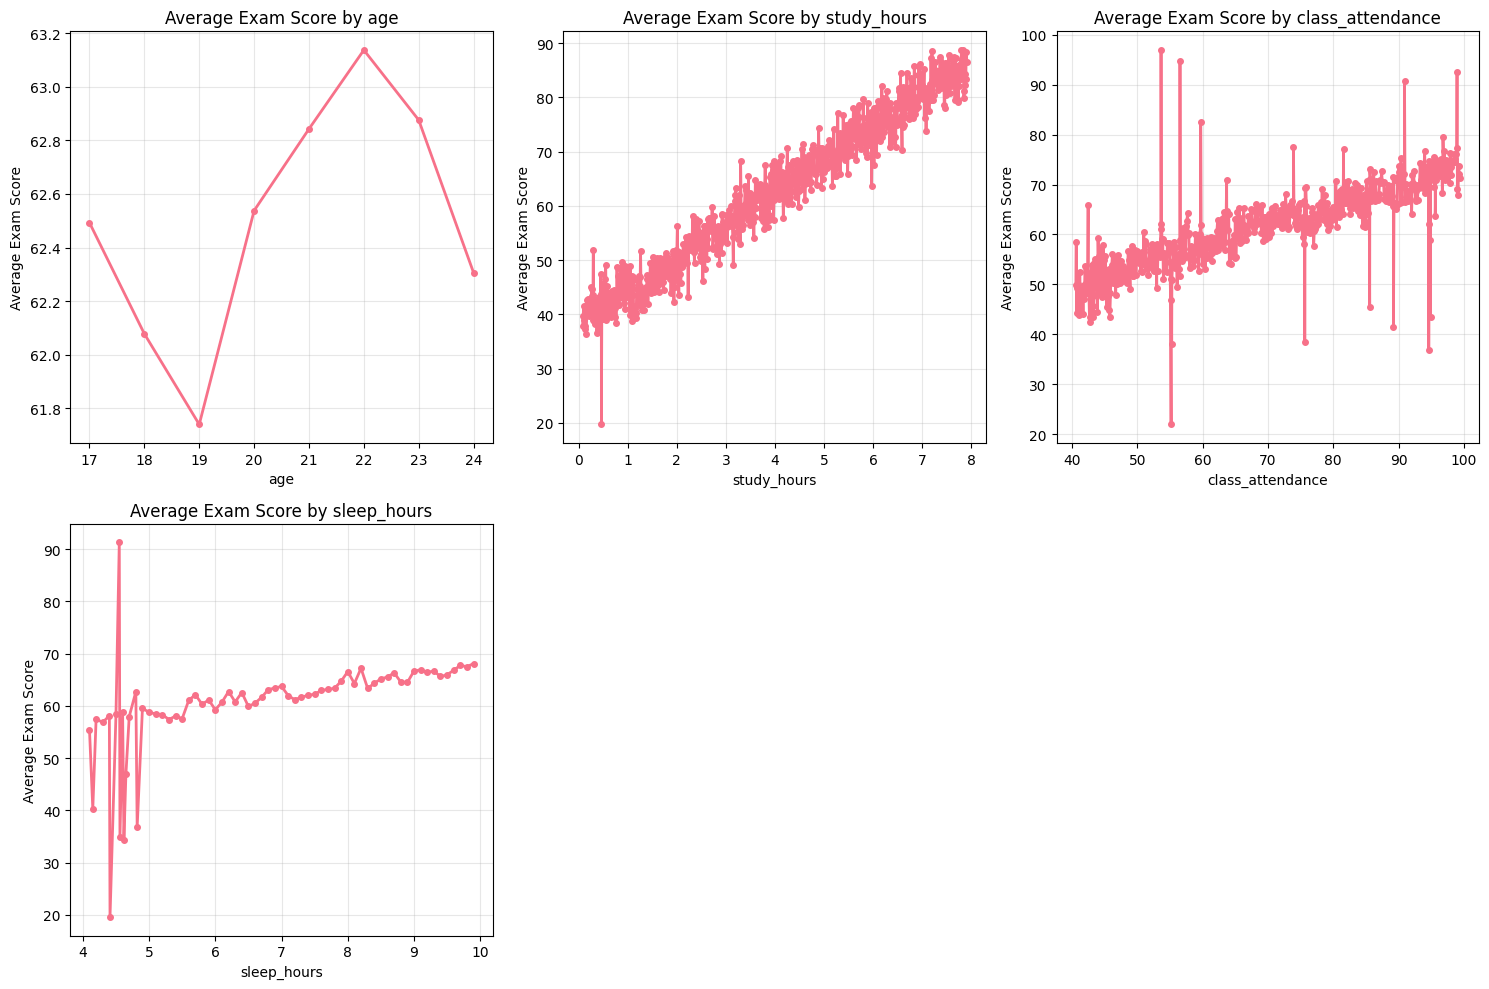

In [9]:
# Set up the plotting style
plt.style.use('default')
sns.set_palette("husl")

# Get numerical columns only (float and int, excluding id and target)
numerical_features = [col for col in df.select_dtypes(include=['float64', 'int64']).columns 
                     if col not in ['id', 'exam_score']]

# Calculate number of rows and columns for subplots
n_features = len(numerical_features)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols

# Create figure with subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes

for i, feature in enumerate(numerical_features):
    ax = axes[i]
    
    # Create line plot for numerical variables
    # Group by the feature and calculate mean exam score
    grouped_data = df.groupby(feature)['exam_score'].mean().reset_index()
    
    ax.plot(grouped_data[feature], grouped_data['exam_score'], marker='o', linewidth=2, markersize=4)
    ax.set_title(f'Average Exam Score by {feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel('Average Exam Score')
    ax.grid(True, alpha=0.3)

# Hide empty subplots
for i in range(n_features, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()


I see solid results, in the categorical columns you can see not too much diferences between categories, being the ones with more diferences the ones you could expect so (sleep_quality and facility_rating) and study_method.
For numerical columns, we can see clear tendencies and some outliers we will study

## Outliers

In [10]:
# Outlier detection using IQR method for all numerical columns
def detect_outliers_iqr(df, column):
    """
    Detect outliers using the IQR method
    """
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    
    return outliers, lower_bound, upper_bound

# Get all numerical columns (including target variable for analysis)
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
if 'id' in numerical_cols:
    numerical_cols.remove('id')  # Remove id column as it's not meaningful for outlier detection

print("OUTLIER ANALYSIS USING IQR METHOD")
print("=" * 50)

outlier_summary = {}

for col in numerical_cols:
    outliers, lower_bound, upper_bound = detect_outliers_iqr(df, col)
    
    print(f"\n{col.upper()}:")
    print(f"  Q1: {df[col].quantile(0.25):.2f}")
    print(f"  Q3: {df[col].quantile(0.75):.2f}")
    print(f"  IQR: {df[col].quantile(0.75) - df[col].quantile(0.25):.2f}")
    print(f"  Lower bound: {lower_bound:.2f}")
    print(f"  Upper bound: {upper_bound:.2f}")
    print(f"  Number of outliers: {len(outliers)}")
    print(f"  Percentage of outliers: {(len(outliers)/len(df))*100:.2f}%")
    
    if len(outliers) > 0:
        print(f"  Outlier range: {outliers[col].min():.2f} to {outliers[col].max():.2f}")
    
    outlier_summary[col] = {
        'count': len(outliers),
        'percentage': (len(outliers)/len(df))*100,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound
    }

print(f"\n{'='*50}")
print("SUMMARY:")
print(f"{'='*50}")
for col, info in outlier_summary.items():
    print(f"{col}: {info['count']} outliers ({info['percentage']:.2f}%)")


OUTLIER ANALYSIS USING IQR METHOD

AGE:
  Q1: 19.00
  Q3: 23.00
  IQR: 4.00
  Lower bound: 13.00
  Upper bound: 29.00
  Number of outliers: 0
  Percentage of outliers: 0.00%

STUDY_HOURS:
  Q1: 1.97
  Q3: 6.05
  IQR: 4.08
  Lower bound: -4.15
  Upper bound: 12.17
  Number of outliers: 0
  Percentage of outliers: 0.00%

CLASS_ATTENDANCE:
  Q1: 57.00
  Q3: 87.20
  IQR: 30.20
  Lower bound: 11.70
  Upper bound: 132.50
  Number of outliers: 0
  Percentage of outliers: 0.00%

SLEEP_HOURS:
  Q1: 5.60
  Q3: 8.60
  IQR: 3.00
  Lower bound: 1.10
  Upper bound: 13.10
  Number of outliers: 0
  Percentage of outliers: 0.00%

EXAM_SCORE:
  Q1: 48.80
  Q3: 76.30
  IQR: 27.50
  Lower bound: 7.55
  Upper bound: 117.55
  Number of outliers: 0
  Percentage of outliers: 0.00%

SUMMARY:
age: 0 outliers (0.00%)
study_hours: 0 outliers (0.00%)
class_attendance: 0 outliers (0.00%)
sleep_hours: 0 outliers (0.00%)
exam_score: 0 outliers (0.00%)


## Target Distribution

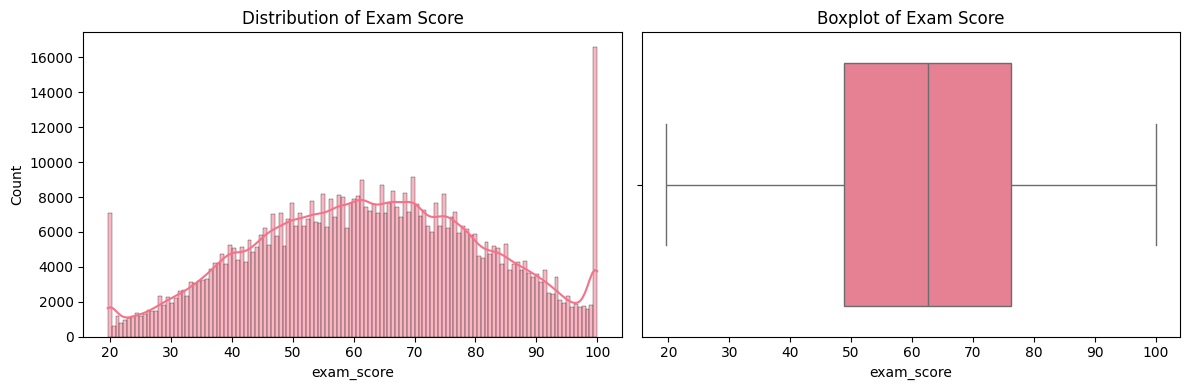

count    630000.000000
mean         62.506672
std          18.916884
min          19.599000
25%          48.800000
50%          62.600000
75%          76.300000
max         100.000000
Name: exam_score, dtype: float64


In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(df['exam_score'], kde=True, ax=axes[0])
axes[0].set_title('Distribution of Exam Score')
sns.boxplot(x=df['exam_score'], ax=axes[1])
axes[1].set_title('Boxplot of Exam Score')
plt.tight_layout()
plt.show()
print(df['exam_score'].describe())

## Correlation

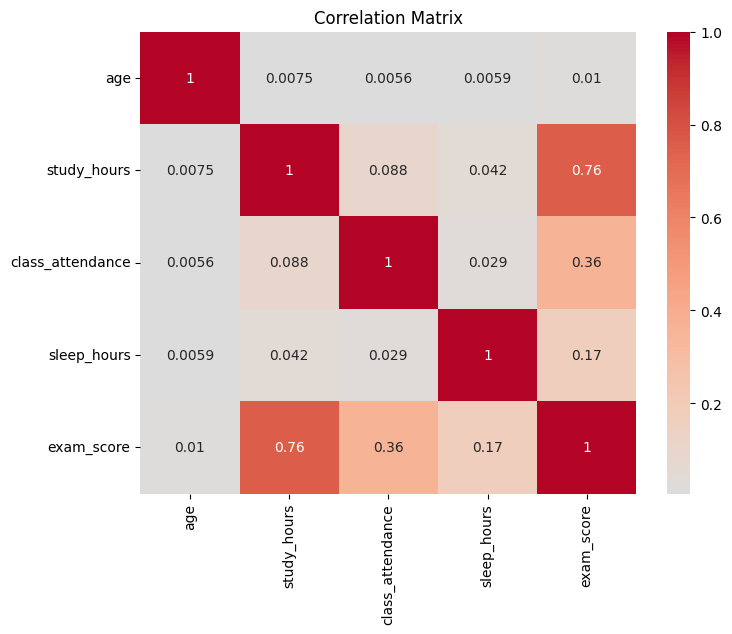

In [12]:
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns.drop('id')
plt.figure(figsize=(8, 6))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

## Train vs Test Distribution

In [13]:
print("Train shape:", df.shape)
print("Test shape:", test_df.shape)

# Verificar que las distribuciones son similares
for col in numerical_cols:
    if col != 'exam_score':
        print(f"\n{col}:")
        print(f"  Train mean: {df[col].mean():.2f}, Test mean: {test_df[col].mean():.2f}")

Train shape: (630000, 13)
Test shape: (270000, 12)

age:
  Train mean: 20.55, Test mean: 20.54

study_hours:
  Train mean: 4.00, Test mean: 4.00

class_attendance:
  Train mean: 71.99, Test mean: 71.98

sleep_hours:
  Train mean: 7.07, Test mean: 7.07


## EDA Conclusions

All data looks clean and ready for modeling:
- **No outliers** detected using IQR method
- **No missing values** or duplicates
- **Balanced distributions** between train and test sets
- **Target variable** (`exam_score`) follows a near-normal distribution
- **Low multicollinearity** between features

Preprocessing needed:
- Categorical encoding for 7 object columns (will be handled during model pipeline)

# Modeling


In [14]:
# Additional imports for modeling
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, TargetEncoder
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import StackingRegressor, HistGradientBoostingRegressor
from sklearn.metrics import root_mean_squared_error
import numpy as np

# Boosting models
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings('ignore')


/usr/local/lib/python3.12/dist-packages/sqlalchemy/orm/query.py:195: SyntaxWarning: "is not" with 'tuple' literal. Did you mean "!="?
  if entities is not ():


## Data Preparation


In [15]:
# Separate features and target
target = 'exam_score'
features = [col for col in df.columns if col not in ['id', target]]

X = df[features].copy()
y = df[target].copy()
X_test = test_df[features].copy()

# Identify categorical columns
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
num_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()

print(f"Features: {len(features)}")
print(f"Categorical: {cat_cols}")
print(f"Numerical: {num_cols}")
print(f"\nTrain shape: {X.shape}")
print(f"Test shape: {X_test.shape}")

Features: 11
Categorical: ['gender', 'course', 'internet_access', 'sleep_quality', 'study_method', 'facility_rating', 'exam_difficulty']
Numerical: ['age', 'study_hours', 'class_attendance', 'sleep_hours']

Train shape: (630000, 11)
Test shape: (270000, 11)


In [16]:
# Use Target Encoding for categorical columns (better for tree-based models)
# sklearn's TargetEncoder replaces categories with the smoothed mean of the target
target_encoder = TargetEncoder(target_type='continuous', smooth='auto')

X_encoded = X.copy()
X_test_encoded = X_test.copy()

# Fit on train categorical columns, transform both
X_encoded[cat_cols] = target_encoder.fit_transform(X[cat_cols], y)
X_test_encoded[cat_cols] = target_encoder.transform(X_test[cat_cols])

print("Target Encoding complete!")
print(f"Encoded {len(cat_cols)} categorical columns")
X_encoded.head()

Target Encoding complete!
Encoded 7 categorical columns


,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty
0,21,62.561117,62.269478,7.91,98.8,62.480980,4.9,62.602607,59.743779,57.905992,62.193692
1,18,62.808284,62.382985,4.95,94.8,62.501897,4.7,56.988558,57.713881,63.005679,62.599094
2,20,62.560404,62.311194,4.68,92.6,62.501897,5.8,56.988558,69.214374,66.697434,62.599094
3,19,62.190505,62.288986,2.00,49.5,62.513988,8.3,62.707543,60.548706,66.708721,62.615155
4,23,62.170955,62.544938,7.65,86.9,62.491037,9.6,67.891174,57.665043,66.712824,62.193692


In [17]:
# Cross-validation setup
N_FOLDS = 5
kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

def evaluate_model(model, X, y, model_name="Model"):
    """
    Evaluate model using K-Fold cross-validation
    Returns RMSE scores and predictions on test set
    """
    oof_preds = np.zeros(len(X))
    test_preds = np.zeros(len(X_test_encoded))
    scores = []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        model.fit(X_train, y_train)
        
        oof_preds[val_idx] = model.predict(X_val)
        test_preds += model.predict(X_test_encoded) / N_FOLDS
        
        fold_rmse = root_mean_squared_error(y_val, oof_preds[val_idx])
        scores.append(fold_rmse)
        print(f"  Fold {fold+1}: RMSE = {fold_rmse:.5f}")
    
    overall_rmse = root_mean_squared_error(y, oof_preds)
    print(f"\n  {model_name} Overall CV RMSE: {overall_rmse:.5f}")
    
    return oof_preds, test_preds, overall_rmse

## Baseline Model (Ridge)

In [18]:
print("Training Ridge (Baseline)...")
ridge = Ridge(alpha=1.0)
ridge_oof, ridge_test, ridge_rmse = evaluate_model(ridge, X_encoded, y, "Ridge")

Training Ridge (Baseline)...
  Fold 1: RMSE = 8.90455
  Fold 2: RMSE = 8.90853
  Fold 3: RMSE = 8.90113
  Fold 4: RMSE = 8.91038
  Fold 5: RMSE = 8.92899

  Ridge Overall CV RMSE: 8.91072


## Hyperparameter Tuning with Optuna


In [19]:
import optuna
from sklearn.model_selection import cross_val_score
optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective(trial):
    """
    Optuna objective function for XGBoost hyperparameter optimization
    """
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 300, 1200),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
        'random_state': 42,
        'n_jobs': -1,
        'verbosity': 0
    }
    
    model = XGBRegressor(**params)
    
    # Use 3-fold CV for speed during optimization
    scores = cross_val_score(model, X_encoded, y, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1)
    
    return -scores.mean()

study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=25, show_progress_bar=True)

print(f"\nBest trial RMSE: {study.best_value:.5f}")
print(f"\nBest hyperparameters:")
for key, value in study.best_params.items():
    print(f"   {key}: {value}")


  0%|          | 0/25 [00:00<?, ?it/s]


Best trial RMSE: 8.77093

Best hyperparameters:
   n_estimators: 553
   max_depth: 7
   learning_rate: 0.0367756027452049
   subsample: 0.9208787923016158
   colsample_bytree: 0.6298202574719083
   min_child_weight: 10
   reg_alpha: 0.7722447692966574
   reg_lambda: 0.1987156815341724


## XGBoost

In [20]:
# Use best hyperparameters from Optuna
print("Training XGBoost with optimized hyperparameters...")
xgb = XGBRegressor(
    **study.best_params,
    random_state=42,
    n_jobs=-1,
    verbosity=0
)
xgb_oof, xgb_test, xgb_rmse = evaluate_model(xgb, X_encoded, y, "XGBoost (Optimized)")


Training XGBoost with optimized hyperparameters...
  Fold 1: RMSE = 8.75306
  Fold 2: RMSE = 8.76493
  Fold 3: RMSE = 8.75712
  Fold 4: RMSE = 8.77195
  Fold 5: RMSE = 8.78734

  XGBoost (Optimized) Overall CV RMSE: 8.76689


## LightGBM

In [21]:
print("Training LightGBM...")
lgb = LGBMRegressor(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)
lgb_oof, lgb_test, lgb_rmse = evaluate_model(lgb, X_encoded, y, "LightGBM")


Training LightGBM...
  Fold 1: RMSE = 8.76667
  Fold 2: RMSE = 8.77782
  Fold 3: RMSE = 8.76848
  Fold 4: RMSE = 8.78503
  Fold 5: RMSE = 8.80147

  LightGBM Overall CV RMSE: 8.77990


## CatBoost

In [22]:
# CatBoost can handle categorical features natively
def evaluate_catboost(X, y, cat_features):
    """
    Evaluate CatBoost with native categorical handling
    """
    oof_preds = np.zeros(len(X))
    test_preds = np.zeros(len(X_test))
    scores = []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        model = CatBoostRegressor(
            iterations=500,
            depth=6,
            learning_rate=0.05,
            random_seed=42,
            verbose=0,
            cat_features=cat_features
        )
        
        model.fit(X_train, y_train)
        
        oof_preds[val_idx] = model.predict(X_val)
        test_preds += model.predict(X_test) / N_FOLDS
        
        fold_rmse = root_mean_squared_error(y_val, oof_preds[val_idx])
        scores.append(fold_rmse)
        print(f"  Fold {fold+1}: RMSE = {fold_rmse:.5f}")
    
    overall_rmse = root_mean_squared_error(y, oof_preds)
    print(f"\n  CatBoost Overall CV RMSE: {overall_rmse:.5f}")
    
    return oof_preds, test_preds, overall_rmse

print("Training CatBoost...")
cat_oof, cat_test, cat_rmse = evaluate_catboost(X, y, cat_cols)


Training CatBoost...
  Fold 1: RMSE = 8.80199
  Fold 2: RMSE = 8.81305
  Fold 3: RMSE = 8.80110
  Fold 4: RMSE = 8.81805
  Fold 5: RMSE = 8.83632

  CatBoost Overall CV RMSE: 8.81411


## Model Comparison & Ensemble

In [23]:
# Compare all models
results = {
    'Ridge': ridge_rmse,
    'XGBoost': xgb_rmse,
    'LightGBM': lgb_rmse,
    'CatBoost': cat_rmse
}

print("=" * 50)
print("MODEL COMPARISON (CV RMSE - lower is better)")
print("=" * 50)
for model, rmse in sorted(results.items(), key=lambda x: x[1]):
    print(f"{model:12s}: {rmse:.5f}")

best_model = min(results, key=results.get)
print(f"\nBest single model: {best_model} ({results[best_model]:.5f})")

MODEL COMPARISON (CV RMSE - lower is better)
XGBoost     : 8.76689
LightGBM    : 8.77990
CatBoost    : 8.81411
Ridge       : 8.91072

Best single model: XGBoost (8.76689)


In [24]:
# Ensemble with optimized weights using scipy.optimize
from scipy.optimize import minimize

# Simple average ensemble first
ensemble_oof_simple = (xgb_oof + lgb_oof + cat_oof) / 3
ensemble_test_simple = (xgb_test + lgb_test + cat_test) / 3
simple_rmse = root_mean_squared_error(y, ensemble_oof_simple)
print(f"Simple Ensemble (1/3 each) CV RMSE: {simple_rmse:.5f}")

# Optimize ensemble weights
def rmse_ensemble(weights):
    """Calculate RMSE for weighted ensemble"""
    pred = weights[0] * xgb_oof + weights[1] * lgb_oof + weights[2] * cat_oof
    return root_mean_squared_error(y, pred)

# Initial weights (equal)
initial_weights = [0.33, 0.33, 0.34]

# Constraints: weights must sum to 1
constraints = {'type': 'eq', 'fun': lambda w: sum(w) - 1}

# Bounds: weights between 0 and 1
bounds = [(0, 1), (0, 1), (0, 1)]

# Optimize
result = minimize(rmse_ensemble, initial_weights, method='SLSQP', 
                  bounds=bounds, constraints=constraints)

optimal_weights = result.x
print(f"\nOptimal weights: XGB={optimal_weights[0]:.3f}, LGB={optimal_weights[1]:.3f}, CAT={optimal_weights[2]:.3f}")

# Calculate optimized ensemble predictions
ensemble_oof_opt = optimal_weights[0] * xgb_oof + optimal_weights[1] * lgb_oof + optimal_weights[2] * cat_oof
ensemble_test_opt = optimal_weights[0] * xgb_test + optimal_weights[1] * lgb_test + optimal_weights[2] * cat_test
optimized_rmse = root_mean_squared_error(y, ensemble_oof_opt)
print(f"Optimized Ensemble CV RMSE: {optimized_rmse:.5f}")

# Map model names to their test predictions
test_predictions_map = {
    'Ridge': ridge_test,
    'XGBoost': xgb_test,
    'LightGBM': lgb_test,
    'CatBoost': cat_test
}

# Add ensembles to results
results['Simple Ensemble'] = simple_rmse
results['Optimized Ensemble'] = optimized_rmse

# Find overall best
print("\n" + "=" * 50)
print("FINAL COMPARISON (including ensembles)")
print("=" * 50)
for model, rmse in sorted(results.items(), key=lambda x: x[1]):
    print(f"{model:20s}: {rmse:.5f}")

best_model = min(results, key=results.get)
print(f"\nBest model: {best_model} ({results[best_model]:.5f})")

# Select final predictions based on best model
if best_model == 'Optimized Ensemble':
    final_predictions = ensemble_test_opt
    final_model = "Optimized Ensemble"
elif best_model == 'Simple Ensemble':
    final_predictions = ensemble_test_simple
    final_model = "Simple Ensemble"
else:
    final_predictions = test_predictions_map[best_model]
    final_model = best_model

Simple Ensemble (1/3 each) CV RMSE: 8.77399

Optimal weights: XGB=0.690, LGB=0.310, CAT=0.000
Optimized Ensemble CV RMSE: 8.76370

FINAL COMPARISON (including ensembles)
Optimized Ensemble  : 8.76370
XGBoost             : 8.76689
Simple Ensemble     : 8.77399
LightGBM            : 8.77990
CatBoost            : 8.81411
Ridge               : 8.91072

Best model: Optimized Ensemble (8.76370)


## Stacking (Meta-Model Approach)

Stacking uses the OOF predictions from base models as features for a meta-model (usually Ridge or similar). This can capture non-linear relationships between model predictions.


In [25]:
# Create stacking features from OOF predictions
stack_train = np.column_stack([xgb_oof, lgb_oof, cat_oof, ridge_oof])
stack_test = np.column_stack([xgb_test, lgb_test, cat_test, ridge_test])

print(f"Stacking features shape: {stack_train.shape}")

# Train meta-model (Ridge with regularization)
from sklearn.linear_model import RidgeCV

# Use cross-validation to find best alpha
meta_model = RidgeCV(alphas=[0.001, 0.01, 0.1, 1.0, 10.0, 100.0], cv=5)
meta_model.fit(stack_train, y)

print(f"Best alpha for meta-model: {meta_model.alpha_}")

# Get stacking predictions
stack_oof_preds = np.zeros(len(y))

# Proper OOF predictions for stacking
for fold, (train_idx, val_idx) in enumerate(kf.split(stack_train)):
    X_train_stack = stack_train[train_idx]
    y_train_stack = y.iloc[train_idx]
    X_val_stack = stack_train[val_idx]
    
    fold_meta = Ridge(alpha=meta_model.alpha_)
    fold_meta.fit(X_train_stack, y_train_stack)
    stack_oof_preds[val_idx] = fold_meta.predict(X_val_stack)

stack_test_preds = meta_model.predict(stack_test)

# Calculate RMSE for stacking
stack_rmse = root_mean_squared_error(y, stack_oof_preds)
print(f"\nStacking CV RMSE: {stack_rmse:.5f}")

# Add to results
results['Stacking'] = stack_rmse

# Update best model comparison
print("\n" + "=" * 50)
print("FINAL COMPARISON (with Stacking)")
print("=" * 50)
for model, rmse in sorted(results.items(), key=lambda x: x[1]):
    marker = "*" if rmse == min(results.values()) else "  "
    print(f"{marker} {model:20s}: {rmse:.5f}")

# Update final predictions if stacking is best
best_overall = min(results, key=results.get)
if best_overall == 'Stacking':
    final_predictions = stack_test_preds
    final_model = "Stacking"
    print(f"\nStacking is the new best model!")


Stacking features shape: (630000, 4)
Best alpha for meta-model: 100.0

Stacking CV RMSE: 8.76113

FINAL COMPARISON (with Stacking)
* Stacking            : 8.76113
   Optimized Ensemble  : 8.76370
   XGBoost             : 8.76689
   Simple Ensemble     : 8.77399
   LightGBM            : 8.77990
   CatBoost            : 8.81411
   Ridge               : 8.91072

Stacking is the new best model!


## Generate Submission

In [26]:
submission = pd.DataFrame({
    'id': test_df['id'],
    'exam_score': final_predictions
})

submission.to_csv('submission.csv', index=False)
print(f"Submission saved using: {final_model}")
print(f"Shape: {submission.shape}")
submission.head(10)

Submission saved using: Stacking
Shape: (270000, 2)


,id,exam_score
0,630000,72.358090
1,630001,70.267781
2,630002,87.611861
3,630003,56.783332
4,630004,47.168338
5,630005,71.116406
6,630006,73.069155
7,630007,59.227404
8,630008,78.506863
9,630009,90.098113


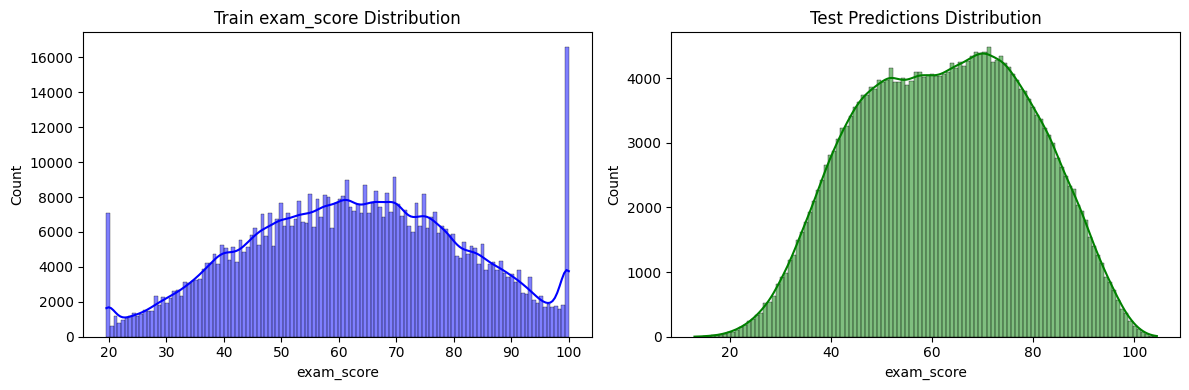


Train stats:      mean=62.51, std=18.92
Prediction stats: mean=62.52, std=16.75


In [27]:
# Sanity check: Compare train vs predicted distributions
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(y, kde=True, ax=axes[0], color='blue', label='Train (actual)')
axes[0].set_title('Train exam_score Distribution')
axes[0].set_xlabel('exam_score')

sns.histplot(final_predictions, kde=True, ax=axes[1], color='green', label='Test (predicted)')
axes[1].set_title('Test Predictions Distribution')
axes[1].set_xlabel('exam_score')

plt.tight_layout()
plt.show()

print(f"\nTrain stats:      mean={y.mean():.2f}, std={y.std():.2f}")
print(f"Prediction stats: mean={final_predictions.mean():.2f}, std={final_predictions.std():.2f}")